導入資料 初步檢查

In [23]:
import warnings
warnings.filterwarnings("ignore")  # 屏蔽 warning

%matplotlib inline

import pandas as pd

df = pd.read_csv('./dataset/train.csv')
print(df.shape)  # 输出 (行数, 列数)
print(df.head(5))

(27643, 3)
   Id  Popularity                                       Page content
0   0          -1  <html><head><div class="article-info"> <span c...
1   1           1  <html><head><div class="article-info"><span cl...
2   2           1  <html><head><div class="article-info"><span cl...
3   3          -1  <html><head><div class="article-info"><span cl...
4   4          -1  <html><head><div class="article-info"><span cl...


預處理資料

In [25]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag, word_tokenize, ne_chunk
from bs4 import BeautifulSoup
import numpy as np
from textstat import flesch_reading_ease
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from joblib import Parallel, delayed
import pandas as pd

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('vader_lexicon')
    nltk.data.find('averaged_perceptron_tagger')
    nltk.data.find('maxent_ne_chunker')
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('vader_lexicon')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('maxent_ne_chunker')
    nltk.download('words')

# ---- 1) 正文起點：出現就截斷其後全部 ----
_BODY_OPEN = re.compile(
    r'(?is)<\s*(section|div|article)\b[^>]*\b'
    r'(?:article-content|article-body|content-body|post-content)\b[^>]*>'
)

# ---- 2) 小工具 ----
_MONTH = dict(jan='01', feb='02', mar='03', apr='04', may='05', jun='06',
              jul='07', aug='08', sep='09', oct='10', nov='11', dec='12')

def _norm(s: str) -> str:
    return re.sub(r'[\W]+', ' ', (s or '').lower()).strip()

def _slug(s: str) -> str:
    """把任意文本做成 token 安全的 slug（保留 a-z0-9_）"""
    return re.sub(r'[^a-z0-9_]+', '', _norm(s).replace(' ', '_'))

def _bucket(n, edges):
    """數值分桶：edges=[0,1,3,5] -> b0_1, b1_3, b3_5, b5p"""
    if n is None:
        return 'unk'
    for i in range(len(edges)-1):
        if edges[i] <= n < edges[i+1]:
            return f"b{edges[i]}_{edges[i+1]}"
    return f"b{edges[-1]}p"

def _aspect_bucket(w, h):
    if not w or not h:
        return 'unk'
    r = w / h
    if r < 0.9: return 'tall'
    if r < 1.2: return 'squareish'
    if r < 1.8: return 'landscape'
    return 'ultrawide'

def _img_size_bucket(w, h):
    if not w or not h:
        return 'unk'
    area = w * h
    if area < 80_000: return 'xs'
    if area < 230_000: return 'sm'     # ~640x360
    if area < 920_000: return 'md'     # ~1280x720
    if area < 2_100_000: return 'lg'   # ~1920x1080
    return 'xl'

def _parse_wh_from_src(src: str):
    """從 URL 中粗略抓取 .../950x534/... 這樣的尺寸"""
    if not src:
        return None, None
    m = re.search(r'/(\d{2,5})x(\d{2,5})/', src)
    if m:
        return int(m.group(1)), int(m.group(2))
    return None, None

# ---- 3) 模擬動態趨勢關鍵詞（模擬 Google Trends 或 X 熱門話題） ----
TRENDING_TOPICS = {
    'elon_musk', 'ai', 'climate_change', 'covid', 'blockchain', 'taiwan',
    'tesla', 'space', 'crypto', 'elections'
}

# ---- 4) 預訓練 LDA 模型 ----
def pretrain_lda(df, column='Page content', n_components=10, max_features=1000, max_text_len=500):
    """預訓練 LDA 模型並返回 vectorizer 和 lda 模型"""
    # 提取頭部內容並轉為純文本
    def extract_text(html):
        if not isinstance(html, str) or not html.strip():
            return ""
        m = _BODY_OPEN.search(html)
        header_html = html[:m.start()] if m else html
        soup = BeautifulSoup(header_html, 'html.parser')
        return ' '.join(soup.get_text().lower().split()[:max_text_len])
    
    # 構建語料庫
    corpus = [extract_text(html) for html in df[column] if isinstance(html, str)]
    corpus = [text if text else "" for text in corpus]  # 確保無空值
    
    if not corpus:
        print("警告：語料庫為空，無法訓練 LDA")
        return None, None
    
    # 訓練 CountVectorizer 和 LDA
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42, n_jobs=-1)
    lda.fit(X)
    return vectorizer, lda

# ---- 5) 增強版預處理：優化 NER 和 LDA ----
def preprocessor(html: str, lda_vectorizer=None, lda_model=None, max_text_len=500) -> tuple:
    if not isinstance(html, str) or not html.strip():
        return "empty_content", set(), "author_unknown channel_unknown publisher_unknown"

    # A) 剪掉正文：只保留正文前（頁眉/標題區）
    m = _BODY_OPEN.search(html)
    header_html = html[:m.start()] if m else html

    # B) 解析 header_html
    soup = BeautifulSoup(header_html, 'html.parser')

    # 標題（優先 h1.title -> h1 -> <title>）
    title_raw = None
    h1 = soup.find('h1', class_=lambda c: (isinstance(c, list) and any('title' in x for x in c)) or (isinstance(c, str) and 'title' in c)) \
         or soup.find('h1')
    if h1:
        title_raw = h1.get_text(' ', strip=True)
    elif soup.title:
        title_raw = soup.title.get_text(' ', strip=True)
    title_tokens = _norm(title_raw)

    # 作者
    author = None
    by = soup.find(class_=lambda c: c and ('byline' in c or 'author_name' in c))
    if by:
        author = by.get_text(' ', strip=True)
    if not author:
        a = soup.find('a', href=re.compile(r'/author/[^/]+/?$', re.I))
        if a:
            author = a.get_text(' ', strip=True)
    author_slug = _slug(re.sub(r'^\s*by\s+', '', author or '', flags=re.I))

    # 頻道/類型
    channel = None
    art = soup.find('article')
    if art and art.has_attr('data-channel'):
        channel = art['data-channel']
    if not channel and art:
        cls = ' '.join(art.get('class', []))
        mch = re.search(r'\b(news|tech|world|sports?|business|entertainment|culture|life|science)\b', cls, re.I)
        if mch: channel = mch.group(1)
    channel_slug = _slug(channel or 'unknown')

    # 發佈者
    publisher = None
    pub = soup.find('a', href=re.compile(r'/publishers/[^/]+/?', re.I))
    if pub:
        publisher = pub.get_text(' ', strip=True) or re.sub(r'.*/publishers/([^/]+)/?.*', r'\1', pub['href'], flags=re.I)
    publisher_slug = _slug(publisher or 'unknown')

    # 時間（年/月/星期/時段/是否週末/季節）
    year = month = weekday = tod = season = None
    is_weekend = None
    tm = soup.find('time')
    dt = tm['datetime'] if (tm and tm.has_attr('datetime')) else (tm.get_text(' ', strip=True) if tm else None)
    if dt:
        y = re.search(r'(20\d{2}|19\d{2})', dt)
        if y: year = y.group(1)
        mo = re.search(r'-(\d{2})-', dt) or re.search(r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', dt, re.I)
        if mo:
            mm = mo.group(1).lower() if mo.lastindex else mo.group(0).lower()
            month = _MONTH.get(mm, mm)
        wd = re.search(r'\b(mon|tue|wed|thu|fri|sat|sun)\b', dt, re.I)
        if wd:
            weekday = wd.group(1).lower()
            is_weekend = weekday in ('sat', 'sun')
        hh = re.search(r'\b(\d{2}):(\d{2})', dt)
        if hh:
            h = int(hh.group(1))
            tod = 'morning' if 5 <= h < 12 else 'afternoon' if 12 <= h < 17 else 'evening' if 17 <= h < 22 else 'night'
        if month:
            m_i = int(month)
            season = 'spring' if 3 <= m_i <= 5 else 'summer' if 6 <= m_i <= 8 else 'autumn' if 9 <= m_i <= 11 else 'winter'

    # 媒體要素：圖片/視頻/鏈接計數 + 圖像（主圖/分辨率）
    imgs = soup.find_all('img')
    img_count = len(imgs)
    has_image = img_count > 0
    leadimg = soup.find(attrs={'data-fragment': 'lead-image'}) is not None

    max_w = max_h = None
    for im in imgs:
        w, h = _parse_wh_from_src(im.get('src', ''))
        if w and h:
            if not max_w or (w * h) > (max_w * max_h if (max_w and max_h) else 0):
                max_w, max_h = w, h
    img_size_bucket = _img_size_bucket(max_w, max_h)
    img_aspect_bucket = _aspect_bucket(max_w, max_h)

    videos = soup.find_all('video')
    iframes = soup.find_all('iframe')
    has_video = bool(videos) or any(re.search(r'(youtube|vimeo|dailymotion)', (fr.get('src') or ''), re.I) for fr in iframes)

    # 其他多媒體類型（音頻、交互元素）
    audio = soup.find_all('audio')
    has_audio = len(audio) > 0
    interactive_elements = soup.find_all(['canvas', 'svg', lambda tag: tag.name == 'div' and 'interactive' in (tag.get('class') or [])])
    has_interactive = len(interactive_elements) > 0

    link_count = len(soup.find_all('a'))
    link_bucket = _bucket(link_count, [0, 1, 3, 6, 10])

    img_bucket = _bucket(img_count, [0, 1, 3, 5])

    # 權威鏈接數量
    authoritative_domains = ['.edu', '.gov', '.org']
    authoritative_links = sum(1 for a in soup.find_all('a') if any(domain in (a.get('href') or '').lower() for domain in authoritative_domains))
    authoritative_link_bucket = _bucket(authoritative_links, [0, 1, 3, 5])

    # 標題可傳播性特徵
    raw = title_raw or ''
    title_has_num = bool(re.search(r'\d', raw))
    title_has_year = bool(re.search(r'\b(19|20)\d{2}\b', raw))
    title_has_q = '?' in raw
    title_has_exclaim = '!' in raw
    title_has_colon = ':' in raw
    is_listicle = bool(re.match(r'^\s*\d+', raw))
    upper_ratio = (sum(ch.isupper() for ch in raw) / max(1, sum(ch.isalpha() for ch in raw)))
    upper_bucket = 'low' if upper_ratio < 0.15 else 'mid' if upper_ratio < 0.4 else 'high'
    title_word_len = len(_norm(raw).split())
    title_char_len = len(re.sub(r'\s+', '', raw))
    tw_bucket = _bucket(title_word_len, [0, 4, 8, 12, 20])
    tc_bucket = _bucket(title_char_len, [0, 30, 60, 90, 140])

    # 社交信號特徵
    social_keywords = ['share', 'twitter', 'facebook', 'linkedin', 'whatsapp', 'telegram']
    social_elements = soup.find_all(lambda tag: any(
        keyword in (tag.get('class') or []) or
        keyword in (tag.get('id') or '') or
        keyword in (tag.get_text().lower())
        for keyword in social_keywords
    ))
    social_count = len(social_elements)
    social_count_bucket = _bucket(social_count, [0, 1, 3, 5])

    # 社交分享計數
    share_count = 0
    for elem in social_elements:
        text = elem.get_text().lower()
        m = re.search(r'(\d+)\s*(shares?|likes?|retweets?)', text, re.I)
        if m:
            share_count += int(m.group(1))
    share_count_bucket = _bucket(share_count, [0, 10, 100, 1000])

    # 評論相關特徵
    comment_selectors = ['.comments', '#comments', '.comment', '.discussion']
    comment_count = 0
    for selector in comment_selectors:
        comment_count += len(soup.select(selector))
    comment_count_bucket = _bucket(comment_count, [0, 1, 3, 5])

    # 情感詞彙檢測（使用 VADER 情感分析，截斷長文本）
    text_content = ' '.join(soup.get_text().lower().split()[:max_text_len])
    vader = SentimentIntensityAnalyzer()
    sentiment_scores = vader.polarity_scores(text_content)
    sentiment_compound = sentiment_scores['compound']
    sentiment_bucket = 'strong_positive' if sentiment_compound > 0.5 else 'positive' if sentiment_compound > 0.05 \
        else 'strong_negative' if sentiment_compound < -0.5 else 'negative' if sentiment_compound < -0.05 else 'neutral'

    positive_words = ['amazing', 'great', 'excellent', 'wonderful', 'best', 'success', 'win', 'good', 'positive']
    negative_words = ['terrible', 'awful', 'bad', 'worst', 'failure', 'lose', 'problem', 'negative']
    pos_count = sum(1 for word in positive_words if word in text_content)
    neg_count = sum(1 for word in negative_words if word in text_content)

    # 緊急程度特徵
    urgency_indicators = ['breaking', 'urgent', 'alert', 'crisis', 'emergency', 'important']
    urgency_count = sum(1 for word in urgency_indicators if word in text_content)
    urgency_count_bucket = _bucket(urgency_count, [0, 1, 3, 5])

    # 問題導向特徵
    question_words = ['what', 'why', 'how', 'when', 'where', 'who']
    question_count = sum(1 for word in question_words if word in text_content)
    question_count_bucket = _bucket(question_count, [0, 1, 3, 5])

    # 頁面結構特徵
    div_count = len(soup.find_all('div'))
    section_count = len(soup.find_all('section'))
    list_count = len(soup.find_all(['ul', 'ol']))
    div_count_bucket = _bucket(div_count, [0, 5, 10, 20, 50])
    section_count_bucket = _bucket(section_count, [0, 1, 3, 5])
    list_count_bucket = _bucket(list_count, [0, 1, 3, 5])

    # 可讀性特徵（使用截斷的文本）
    readability_score = flesch_reading_ease(text_content) if text_content else 0
    readability_bucket = 'very_easy' if readability_score > 80 else 'easy' if readability_score > 60 \
        else 'standard' if readability_score > 50 else 'difficult' if readability_score > 30 else 'very_difficult'

    # 關鍵詞提取（高頻名詞）
    tokens = word_tokenize(text_content)
    tagged = pos_tag(tokens)
    nouns = [word for word, pos in tagged if pos.startswith('NN') and word.lower() not in stopwords.words('english')]
    noun_count = len(nouns)
    noun_count_bucket = _bucket(noun_count, [0, 5, 10, 20, 50])

    # 新增：命名實體識別（NER）
    chunked = ne_chunk(tagged)
    entities = set()
    for chunk in chunked:
        if hasattr(chunk, 'label') and chunk.label() in ['PERSON', 'ORGANIZATION', 'GPE']:
            entity = '_'.join(c[0].lower() for c in chunk)
            entities.add(f'entity_{entity}')
    entity_count = len(entities)
    entity_count_bucket = _bucket(entity_count, [0, 1, 3, 5])

    # 新增：主題建模（LDA，使用預訓練模型）
    if lda_vectorizer and lda_model:
        X = lda_vectorizer.transform([text_content] if text_content else [''])
        topic_dist = lda_model.transform(X)
        dominant_topic = np.argmax(topic_dist[0]) if topic_dist.size > 0 else 0
        topic_score = topic_dist[0][dominant_topic] if topic_dist.size > 0 else 0
        topic_bucket = f'topic_{dominant_topic}_b{_bucket(topic_score, [0, 0.5, 0.7, 0.9])}'
    else:
        topic_bucket = 'topic_unk'

    # 新增：動態趨勢匹配
    trending_matches = sum(1 for word in tokens if word.lower() in TRENDING_TOPICS)
    trending_bucket = _bucket(trending_matches, [0, 1, 3, 5])

    # 新增：用戶參與數據（模擬點擊量、分享數、評論數）
    engagement_metrics = {'clicks': 0, 'shares': share_count, 'comments': comment_count}
    click_elements = soup.find_all(lambda tag: 'click' in tag.get_text().lower() and re.search(r'\d+', tag.get_text()))
    for elem in click_elements:
        m = re.search(r'(\d+)\s*clicks?', elem.get_text(), re.I)
        if m:
            engagement_metrics['clicks'] += int(m.group(1))
    clicks_bucket = _bucket(engagement_metrics['clicks'], [0, 100, 1000, 10000])
    shares_bucket = _bucket(engagement_metrics['shares'], [0, 10, 100, 1000])
    comments_bucket = _bucket(engagement_metrics['comments'], [0, 1, 10, 50])

    # 行動召喚（CTA）特徵
    cta_phrases = ['read more', 'subscribe now', 'click here', 'learn more', 'join us', 'sign up']
    cta_count = sum(1 for phrase in cta_phrases if phrase in text_content)
    cta_count_bucket = _bucket(cta_count, [0, 1, 3, 5])

    # 內容長度特徵
    header_word_count = len(text_content.split())
    header_word_count_bucket = _bucket(header_word_count, [0, 50, 100, 200, 500])

    # 拼接元特徵 token（全部小寫，確保被 tokenizer 保留）
    feats = []
    # 結構類
    feats += [
        f'author_{author_slug or "unknown"}',
        f'channel_{channel_slug}',
        f'publisher_{publisher_slug}',
        f'year_{year or "unk"}',
        f'month_{month or "unk"}',
        f'weekday_{weekday or "unk"}',
        f'tod_{tod or "unk"}',
        f'season_{season or "unk"}',
        'weekend' if is_weekend else 'weekday' if is_weekend is not None else 'weekend_unk',
    ]
    # 媒體/鏈接
    feats += [
        'has_image' if has_image else 'no_image',
        f'imgcnt_{img_bucket}',
        'has_leadimg' if leadimg else 'no_leadimg',
        f'imgsize_{img_size_bucket}',
        f'imgaspect_{img_aspect_bucket}',
        'has_video' if has_video else 'no_video',
        'has_audio' if has_audio else 'no_audio',
        'has_interactive' if has_interactive else 'no_interactive',
        f'linkcnt_{link_bucket}',
        f'authoritative_links_{authoritative_link_bucket}',
    ]
    # 標題形態
    feats += [
        'is_listicle' if is_listicle else 'not_listicle',
        'title_has_num' if title_has_num else 'title_no_num',
        'title_has_year' if title_has_year else 'title_no_year',
        'title_has_q' if title_has_q else 'title_no_q',
        'title_has_exclaim' if title_has_exclaim else 'title_no_exclaim',
        'title_has_colon' if title_has_colon else 'title_no_colon',
        f'title_len_word_{tw_bucket}',
        f'title_len_char_{tc_bucket}',
        f'title_upper_{upper_bucket}',
    ]
    # 社交信號
    feats += [
        f'social_buttons_{social_count_bucket}',
        f'comment_sections_{comment_count_bucket}',
        f'share_count_{shares_bucket}',
    ]
    # 情感特徵
    feats += [
        f'positive_words_{pos_count}',
        f'negative_words_{neg_count}',
        f'sentiment_{sentiment_bucket}',
    ]
    # 內容特徵
    feats += [
        f'urgency_indicators_{urgency_count_bucket}',
        f'question_words_{question_count_bucket}',
        f'noun_count_{noun_count_bucket}',
        f'cta_count_{cta_count_bucket}',
    ]
    # 結構特徵
    feats += [
        f'div_count_{div_count_bucket}',
        f'section_count_{section_count_bucket}',
        f'list_count_{list_count_bucket}',
        f'readability_{readability_bucket}',
    ]
    # 內容長度
    feats += [
        f'header_word_count_{header_word_count_bucket}',
    ]
    # 新增特徵
    feats += [
        f'entity_count_{entity_count_bucket}',
        topic_bucket,
        f'trending_matches_{trending_bucket}',
        f'clicks_{clicks_bucket}',
        f'shares_{shares_bucket}',
        f'comments_{comments_bucket}',
    ]
    # 命名實體
    feats += list(entities)

    # 返回標題詞、實體集合和元特徵
    return title_tokens, entities, ' '.join(feats)

# ---- 6) 修改 tokenizer 以使用緩存的實體 ----
porter = PorterStemmer()
STOP = set(stopwords.words('english'))

def tokenizer_stem_keepmeta(text: str, entities: set) -> list:
    toks = re.split(r'\s+', (text or '').strip())
    out = []
    # 直接使用 preprocessor 傳入的實體集合，無需重複 NER
    for w in toks:
        if not w:
            continue
        # 保留元特徵、數字或命名實體
        if '_' in w or any(ch.isdigit() for ch in w) or (w.startswith('entity_') and w[7:] in entities):
            out.append(w)
        # 純英文詞：去停用詞 + 詞幹
        elif w.lower() not in STOP and re.fullmatch(r'[a-zA-Z]+', w):
            out.append(porter.stem(w.lower()))
    return out

# ---- 7) 批量處理函數 ----
def process_dataframe(df, column='Page content', lda_vectorizer=None, lda_model=None, max_text_len=500, n_jobs=-1):
    """批量處理 DataFrame 的指定列"""
    def process_row(html, index):
        title_tokens, entities, feats = preprocessor(html, lda_vectorizer, lda_model, max_text_len)
        combined_text = ' '.join([title_tokens, feats]).strip()
        tokens = tokenizer_stem_keepmeta(combined_text, entities)
        return index, tokens
    
    # 使用並行處理
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(html, i) for i, html in enumerate(df[column])
    )
    
    # 按原始索引排序並存儲結果
    processed = [None] * len(df)
    for index, tokens in results:
        processed[index] = ' '.join(tokens)
    
    return pd.Series(processed, index=df.index)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunke

In [26]:
import nltk
nltk.download('words')

# 處理前5行
processed = df['Page content'].head(5).map(preprocessor)

for i, text in enumerate(processed):
    print(f"=== 文本 {i} ===")
    print(text[:500])   # 只打印前500字方便看
    print()

=== 文本 0 ===
('nasa s grand challenge stop asteroids from destroying earth', set(), 'author_clara_moskowitz channel_world publisher_space_com year_2013 month_06 weekday_wed tod_afternoon season_summer weekday has_image imgcnt_b1_3 has_leadimg imgsize_md imgaspect_landscape no_video no_audio no_interactive linkcnt_b1_3 authoritative_links_b0_1 not_listicle title_no_num title_no_year title_no_q title_no_exclaim title_has_colon title_len_word_b8_12 title_len_char_b30_60 title_upper_mid social_buttons_b0_1 comment_sections_b0_1 share_count_b0_10 positive_words_0 negative_words_0 sentiment_negative urgency_indicators_b0_1 question_words_b0_1 noun_count_b5_10 cta_count_b0_1 div_count_b0_5 section_count_b0_1 list_count_b0_1 readability_standard header_word_count_b0_50 entity_count_b0_1 topic_unk trending_matches_b0_1 clicks_b0_100 shares_b0_10 comments_b0_1')

=== 文本 1 ===
('google s new open source patent pledge we won t sue unless attacked first', set(), 'author_christina_warren_2013_03_28_

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\11958\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


核心外學習

In [ ]:
import re
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from scipy import sparse as sp
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import text as sk_text


# ========== 预处理（保持你的函数名，做了稳健性增强） ==========
try:
    import nltk
    from nltk.corpus import stopwords as nltk_sw
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('stopwords')
    STOP_WORDS = set(nltk_sw.words('english'))
except Exception:
    # 回退到 sklearn 停用词，避免离线环境崩溃
    STOP_WORDS = set(sk_text.ENGLISH_STOP_WORDS)

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
_emoticon_re = re.compile(r'(?::|;|=|X)(?:-)?(?:\)|\(|D|P)')

# ========== 数据流 & 划分 ==========
def get_stream(path, size):
    """按批读取，流式产生 DataFrame；把Popularity从{-1,1}映射到{0,1}。"""
    for chunk in pd.read_csv(path, chunksize=size):
        if 'Popularity' in chunk.columns:
            chunk['Popularity'] = (chunk['Popularity'].astype(int) == 1).astype(int)
        yield chunk

def get_data_streams(path, train_size=20000, val_size=6000, batch_size=500):
    """创建独立的训练与验证流（你的原框架：先整体读，再切分）。"""
    df = pd.read_csv(path)
    df['Popularity'] = (df['Popularity'].astype(int) == 1).astype(int)

    train_df = df.iloc[:train_size].reset_index(drop=True)
    val_df   = df.iloc[train_size:train_size+val_size].reset_index(drop=True)

    def train_generator():
        for i in range(0, len(train_df), batch_size):
            batch = train_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    def val_generator():
        for i in range(0, len(val_df), batch_size):
            batch = val_df.iloc[i:i+batch_size]
            if len(batch) > 0:
                yield batch

    return train_generator(), val_generator(), len(train_df), len(val_df)

# ========== 预训练 LDA ==========
# 在训练前运行，获取 LDA 模型
TRAIN_PATH = './dataset/train.csv'
df = pd.read_csv(TRAIN_PATH)
df = df.dropna(subset=['Page content'])
df['Page content'] = df['Page content'].astype(str)
lda_vectorizer, lda_model = pretrain_lda(df, column='Page content', n_components=10, max_features=1000)

# ========== 数据流配置 ==========
BATCH_SIZE = 200
TRAIN_SIZE = 26000
VAL_SIZE = 1000

train_stream, val_stream, train_size, val_size = get_data_streams(
    TRAIN_PATH, train_size=TRAIN_SIZE, val_size=VAL_SIZE, batch_size=BATCH_SIZE
)

iters = int((TRAIN_SIZE + BATCH_SIZE - 1) / BATCH_SIZE)  # 向上取整

# ========== 向量器（内存友好的 Hashing） ==========
hashvec = HashingVectorizer(
    n_features=2**22,
    alternate_sign=False,
    ngram_range=(2,3),
    # 不直接使用 preprocessor 和 tokenizer，因为需要处理 entities
)

def featurize(html_series: pd.Series, lda_vectorizer=None, lda_model=None) -> sp.csr_matrix:
    """处理 preprocessor 的元组输出，并手动调用 tokenizer_stem_keepmeta"""
    # 应用 preprocessor，获取 title_tokens, entities, feats
    processed = html_series.astype(str).apply(lambda x: preprocessor(x, lda_vectorizer, lda_model))
    # 将 title_tokens 和 feats 拼接为字符串，entities 传递给 tokenizer
    texts = processed.apply(lambda x: ' '.join([x[0], x[2]]).strip() if x[0] and x[2] else x[0] or x[2])
    entities_list = processed.apply(lambda x: x[1])
    
    # 手动调用 tokenizer_stem_keepmeta
    tokenized = [tokenizer_stem_keepmeta(text, entities) for text, entities in zip(texts, entities_list)]
    
    # 将 tokenized 结果传递给 HashingVectorizer
    return hashvec.transform([' '.join(tokens) for tokens in tokenized])

# ========== 模型 ==========
classes = np.array([0, 1])

clf = SGDClassifier(
    loss="hinge",
    penalty="elasticnet",
    alpha=1e-3,
    l1_ratio=0.15,
    learning_rate="constant",
    eta0=10000,
    average=True,
    max_iter=1,
    tol=None,
    random_state=42
)

# ========== 评估函数：每个iter对“整個驗證集”計算AUC ==========
def eval_val_auc_full(clf, val_batches, vectorizer, lda_vectorizer=None, lda_model=None, use_decision_function=True):
    """逐批transform、逐批取分数，最后一次性算AUC（省内存）。"""
    all_scores, all_targets = [], []
    for vb in val_batches:
        Xv = featurize(vb['Page content'], lda_vectorizer, lda_model)
        if use_decision_function and hasattr(clf, "decision_function"):
            sv = clf.decision_function(Xv)
            scores = sv if sv.ndim == 1 else sv[:, 1]
        else:
            scores = clf.predict_proba(Xv)[:, 1]
        all_scores.append(scores)
        all_targets.append(vb['Popularity'].values)
    y = np.concatenate(all_targets)
    s = np.concatenate(all_scores)
    if np.unique(y).size < 2:
        return np.nan
    return roc_auc_score(y, s)

# ========== 训练循环 ==========
train_auc_hist, val_auc_hist = [], []

# 把验证生成器“固化”为列表，便于每步都能完整评估
val_batches = list(val_stream)

EVAL_EVERY = 1  # 每K步评估一次全量验证集AUC；设为1就是每步都评估

for i in range(iters):
    try:
        # ===== 训练 =====
        train_batch = next(train_stream)
        X_train = train_batch['Page content']
        y_train = train_batch['Popularity'].values

        X_train_vec = featurize(X_train, lda_vectorizer, lda_model)

        if i == 0:
            clf.partial_fit(X_train_vec, y_train, classes=classes)
        else:
            clf.partial_fit(X_train_vec, y_train)

        # 训练AUC（用 decision_function；AUC 对单调变换不敏感）
        if np.unique(y_train).size == 2:
            train_scores = clf.decision_function(X_train_vec)
            train_auc = roc_auc_score(y_train, train_scores)
        else:
            train_auc = np.nan
        train_auc_hist.append(train_auc)

        # ===== 验证：整個驗證集（流式按批累加）=====
        if (i + 1) % EVAL_EVERY == 0:
            full_val_auc = eval_val_auc_full(clf, val_batches, hashvec, lda_vectorizer, lda_model, use_decision_function=True)
            val_auc_hist.append(full_val_auc)
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}, "
                  f"Full Val AUC: {'%.4f' % full_val_auc if np.isfinite(full_val_auc) else 'nan'}")
        else:
            print(f"[{i+1}/{iters}] Train AUC: "
                  f"{'%.4f' % train_auc if np.isfinite(train_auc) else 'nan'}")

    except StopIteration:
        print("數據流已結束")
        break

# ========== 最终一次全量验证 ==========
final_val_auc = eval_val_auc_full(clf, val_batches, hashvec, lda_vectorizer, lda_model, use_decision_function=True)
print(f"Final Full Val AUC: {final_val_auc:.4f}")

[1/130] Train AUC: 0.7241, Full Val AUC: 0.5239
[2/130] Train AUC: 0.7319, Full Val AUC: 0.5366
[3/130] Train AUC: 0.7084, Full Val AUC: 0.5663
[4/130] Train AUC: 0.6012, Full Val AUC: 0.5742
[5/130] Train AUC: 0.6743, Full Val AUC: 0.5695
[6/130] Train AUC: 0.5915, Full Val AUC: 0.5564
[7/130] Train AUC: 0.6647, Full Val AUC: 0.5534
[8/130] Train AUC: 0.6175, Full Val AUC: 0.5650
[9/130] Train AUC: 0.6256, Full Val AUC: 0.5625
[10/130] Train AUC: 0.5966, Full Val AUC: 0.5568
[11/130] Train AUC: 0.6121, Full Val AUC: 0.5559
[12/130] Train AUC: 0.6141, Full Val AUC: 0.5513
[13/130] Train AUC: 0.6107, Full Val AUC: 0.5588
[14/130] Train AUC: 0.6441, Full Val AUC: 0.5571
[15/130] Train AUC: 0.6180, Full Val AUC: 0.5550
[16/130] Train AUC: 0.5608, Full Val AUC: 0.5572
[17/130] Train AUC: 0.5609, Full Val AUC: 0.5531
[18/130] Train AUC: 0.5585, Full Val AUC: 0.5549
[19/130] Train AUC: 0.5671, Full Val AUC: 0.5554
[20/130] Train AUC: 0.5956, Full Val AUC: 0.5510
[21/130] Train AUC: 0.6335, F

繪製學習曲線

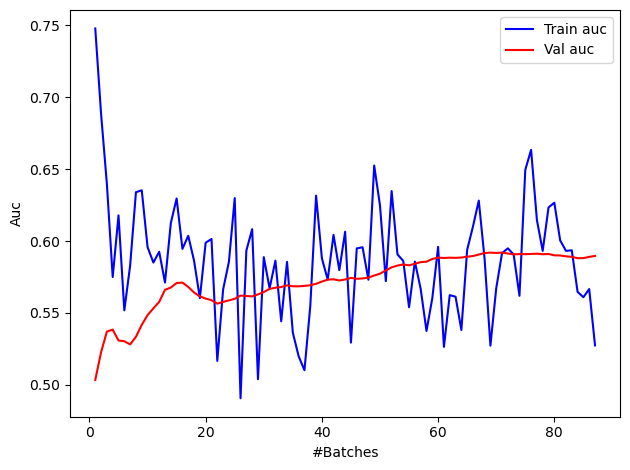

In [13]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc_hist)+1), train_auc_hist, color='blue', label='Train auc')
plt.plot(
    np.linspace(1, len(train_auc_hist), len(val_auc_hist)), 
    val_auc_hist, 
    color='red', 
    label='Val auc'
)
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

校准

In [6]:
# ====== 1) 用“最佳”clf在验证集上做概率校准 ======
from sklearn.calibration import CalibratedClassifierCV
from scipy.sparse import vstack
import numpy as np

# 你前面已经把验证流固化成了 val_batches = list(val_stream)
# 如果你用的是 featurize(...)（比如双通道词+字），就用它；
# 如果你是单个 hashvec，就把下面的 featurize(...) 换成 hashvec.transform(...)

Xv_list, yv_list = [], []
for vb in val_batches:
    Xv_list.append(featurize(vb['Page content']))   # ← 或者：hashvec.transform(vb['Page content'].astype(str))
    yv_list.append(vb['Popularity'].values)

X_val = vstack(Xv_list, format='csr')
y_val = np.concatenate(yv_list)

# 用已训练好的 clf 做“预拟合”校准
# 验证集较小（你设的是 1000），优先用 'sigmoid'(Platt)；'isotonic' 更灵活但容易过拟合
cal_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
cal_clf.fit(X_val, y_val)

# （可选）看看“校准后”的验证 AUC
from sklearn.metrics import roc_auc_score
val_pred_cal = cal_clf.predict_proba(X_val)[:, 1]
print(f"Calibrated Val AUC: {roc_auc_score(y_val, val_pred_cal):.4f}")

# ====== 2) 用校准后的模型生成测试集预测 ======
df_test = pd.read_csv('./dataset/test.csv')
Xt = featurize(df_test['Page content'])             # ← 或者：hashvec.transform(...)
test_pred = cal_clf.predict_proba(Xt)[:, 1]

submission = pd.DataFrame({'Id': df_test['Id'], 'Popularity': test_pred})
submission.to_csv('output/submission_46.csv', index=False)
print('Saved: output/submission_46.csv')

# （可选）持久化校准后的模型，之后直接加载 cal_clf 用
import _pickle as pkl, os
os.makedirs('output', exist_ok=True)
pkl.dump(cal_clf, open('output/clf-calibrated.pkl', 'wb'))


Calibrated Val AUC: 0.5752


KeyboardInterrupt: 

定期保存

In [14]:
# import optimized pickle written in C for serializing and
# de-serializing a Python object
import _pickle as pkl

# dump to disk
pkl.dump(hashvec, open('output/hashvec.pkl', 'wb'))
pkl.dump(clf, open('output/clf-sgd.pkl', 'wb'))

# load from disk
hashvec = pkl.load(open('output/hashvec.pkl', 'rb'))
clf = pkl.load(open('output/clf-sgd.pkl', 'rb'))

df_test = pd.read_csv('./dataset/test.csv')
import scipy as sp
test_pred = sp.special.expit(clf.decision_function(hashvec.transform(df_test['Page content'])))

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'Popularity': test_pred
})
submission.to_csv('output/submission_48.csv', index=False)
print('Test predictions saved to output/submission_48.csv')

Test predictions saved to output/submission_48.csv


修正精度

In [ ]:
import pandas as pd
from decimal import Decimal, ROUND_HALF_UP

df = pd.read_csv('output/submission.csv', usecols=['Id', 'Popularity'])

# Popularity 严格四舍五入到一位小数（ROUND_HALF_UP）
df['Popularity'] = df['Popularity'].map(
    lambda x: float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))
).astype('float32')

# Id 保持整数（可选）
df['Id'] = df['Id'].astype('int64')

# 写出新文件
df.to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('saved -> output/submission_23.csv')

溫度縮放

In [ ]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from decimal import Decimal, ROUND_HALF_UP

# 讀原始提交
df = pd.read_csv('output/submission.csv')
col = 'Popularity' if 'Popularity' in df.columns else 'Predicted'

# 1) 溫度縮放：T<1 拉開（0.6~0.9 可調；0.7 通常效果明顯）
T = 0.005
p = df[col].to_numpy(np.float64)
p = np.clip(p, 1e-6, 1-1e-6)          # 防溢出
p_stretch = expit(logit(p) / T)       # 嚴格單調 → 排序不變（AUC 幾乎不變）

# 2) 四捨五入到一位小數（避免銀行家捨入）
def round1_half_up(x):
    return float(Decimal(str(x)).quantize(Decimal('0.0'), rounding=ROUND_HALF_UP))

p_1dp = np.array([round1_half_up(x) for x in p_stretch], dtype=np.float32)
p_1dp = np.clip(p_1dp, 0.0, 1.0)      # 邊界保險

# 3) 輸出：單精度 + 一位小數（減少並列但滿足賽制）
df[col] = p_1dp.astype(np.float32)
df[['Id', col]].to_csv('output/submission_23.csv', index=False, float_format='%.1f')
print('Saved -> output/submission_23.csv')
